# Model: Logistic Regression with all the columns

In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with all the features). 
The goal is to get the best f1-score ! May the force be with you 🧨🧨  

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score,precision_score, RocCurveDisplay
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from IPython.display import display

/home/nick/.virtualenvs/conversion-rate-challenge/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read file with labels

In [2]:
data = pd.read_csv('../data/processed/conversion_data_train_EDA_without_outliers_fe_output.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284578, 9)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,China,22,1,Direct,2,0,4,44,1936
1,UK,21,1,Ads,3,0,9,63,3969
2,Germany,20,0,Seo,14,1,196,280,78400
3,US,23,1,Seo,3,0,9,69,4761
4,US,28,1,Direct,3,0,9,84,7056


# Make your model

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [4]:
target_variable = 'converted'
X = data.drop(columns=[target_variable])
Y = data.loc[:, target_variable]
print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'total_pages_visited_x2', 'total_pages_visited_age',
       'total_pages_visited_age_x2'],
      dtype='object')



In [5]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=925662591, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Training pipeline

In [6]:
# Put here all the preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Create pipeline for numeric features
display(X.select_dtypes(exclude='object') )
numeric_features = X.select_dtypes(exclude='object').columns  # Names of numeric columns in X_train/X_test
numeric_transformer = Pipeline(
    steps=[
        (
            "scaler", 
            StandardScaler()
        ),
    ]
)

display(X.select_dtypes(include='object') )

# Create pipeline for categorical features
categorical_features = X.select_dtypes(include='object').columns  # Names of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
        (
            "encoder",
            OneHotEncoder(drop="first"),
        ),  # first column will be dropped to avoid creating correlations between features
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
print("...Done.")
print(
    X_train[0:5]
)  # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...


,age,new_user,total_pages_visited,total_pages_visited_x2,total_pages_visited_age,total_pages_visited_age_x2
0,22,1,2,4,44,1936
1,21,1,3,9,63,3969
2,20,0,14,196,280,78400
3,23,1,3,9,69,4761
4,28,1,3,9,84,7056
...,...,...,...,...,...,...
284573,36,1,1,1,36,1296
284574,31,1,2,4,62,3844
284575,41,1,5,25,205,42025
284576,31,1,4,16,124,15376


,country,source
0,China,Direct
1,UK,Ads
2,Germany,Seo
3,US,Seo
4,US,Direct
...,...,...
284573,US,Ads
284574,US,Seo
284575,US,Seo
284576,US,Direct


Performing preprocessings on train set...
        country  age  new_user  source  total_pages_visited  \
35058        US   49         1     Seo                    7   
169755  Germany   26         0  Direct                    4   
173120    China   39         0  Direct                    9   
249159       US   39         0     Seo                    4   
40032     China   33         1     Seo                    2   

        total_pages_visited_x2  total_pages_visited_age  \
35058                       49                      343   
169755                      16                      104   
173120                      81                      351   
249159                      16                      156   
40032                        4                       66   

        total_pages_visited_age_x2  
35058                       117649  
169755                       10816  
173120                      123201  
249159                       24336  
40032                         4356  
..

In [7]:
# Train model
print("Train model...")

def objective_simplified(trial):
    # Fixed solver for simplicity, as it supports both l1 and l2 penalties
    solver = 'liblinear'

    # Define the hyperparameter search space
    # C: Inverse of regularization strength; must be a positive float.
    C = trial.suggest_float('C', 1e-4, 1e2, log = True)

    # penalty: Used to specify the norm of the penalty. 'liblinear' supports 'l1' and 'l2'.
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    # max_iter: Maximum number of iterations taken for the solvers to converge.
    max_iter = trial.suggest_int('max_iter', 200, 1000) # 'liblinear' is generally faster, so lower max_iter is fine

    # Create the Logistic Regression model
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=max_iter,
        random_state=42, # For reproducibility
    )

    # Use cross-validation to get a more robust estimate of model performance
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # We will maximize ROC AUC as our objective metric
    scores = cross_val_score(model, X_train, Y_train, cv=kf, scoring='f1', n_jobs=-1)

    # Return the mean ROC AUC score
    return scores.mean()

study_rf = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, # Number of trials to run without pruning
    n_warmup_steps=0,   # Number of intermediate reports to wait for before starting pruning
    interval_steps=1    # Check for pruning at every 'interval_steps' intermediate reports
))

study_rf.optimize(objective_simplified, n_trials=100) 

print("Best hyperparameters (LogisticRegression): ", study_rf.best_params)
print("Best validation F1-score (LogisticRegression): ", study_rf.best_value)

classifier = LogisticRegression(**study_rf.best_params, solver='liblinear', random_state=42)
classifier.fit(X_train, Y_train)
print("...Done.")

[I 2025-06-11 23:13:56,804] A new study created in memory with name: no-name-512c327b-9f31-455d-9c6a-55a56d16a779


Train model...


[I 2025-06-11 23:13:59,139] Trial 0 finished with value: 0.6932707470163382 and parameters: {'C': 0.0009213947987780145, 'penalty': 'l1', 'max_iter': 318}. Best is trial 0 with value: 0.6932707470163382.
[I 2025-06-11 23:14:00,468] Trial 1 finished with value: 0.37703597019938606 and parameters: {'C': 0.00010441058456351357, 'penalty': 'l1', 'max_iter': 622}. Best is trial 0 with value: 0.6932707470163382.
[I 2025-06-11 23:14:06,820] Trial 2 finished with value: 0.7372335062775058 and parameters: {'C': 0.006722988054121752, 'penalty': 'l1', 'max_iter': 817}. Best is trial 2 with value: 0.7372335062775058.
[I 2025-06-11 23:14:08,103] Trial 3 finished with value: 0.7144229678189745 and parameters: {'C': 0.0027228194304146696, 'penalty': 'l2', 'max_iter': 415}. Best is trial 2 with value: 0.7372335062775058.
[I 2025-06-11 23:14:09,119] Trial 4 finished with value: 0.6948298533880959 and parameters: {'C': 0.001304895388061082, 'penalty': 'l1', 'max_iter': 305}. Best is trial 2 with value: 

Best hyperparameters (LogisticRegression):  {'C': 1.993327899763547, 'penalty': 'l1', 'max_iter': 812}
Best validation F1-score (LogisticRegression):  0.7646403245222796
...Done.


In [8]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



## Test pipeline

In [9]:
# Use X_test, and the same preprocessings as in training pipeline, 
# but call "transform()" instead of "fit_transform" methods (see example below)

print("Encoding categorical features and standardizing numerical features...")

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(
    X_test
)  # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print("...Done.")
print(
    X_test[0:5, :]
)  # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Encoding categorical features and standardizing numerical features...
Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited  \
35367    China   30         1  Direct                    8   
236725      US   41         1     Seo                    1   
41000       UK   29         0     Seo                    2   
41435       US   45         1     Seo                    2   
18633    China   33         1     Seo                    8   

        total_pages_visited_x2  total_pages_visited_age  \
35367                       64                      240   
236725                       1                       41   
41000                        4                       58   
41435                        4                       90   
18633                       64                      264   

        total_pages_visited_age_x2  
35367                        57600  
236725                        1681  
41000                         3364  
41435        

In [10]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]



## Performance assessment

In [11]:
import plotly.express as px

column_names = [col.split('__')[1] for col in preprocessor.get_feature_names_out()]
print("Names of columns corresponding to each coefficient: ", column_names)
coefs = pd.DataFrame(index = column_names, data = classifier.coef_[0].transpose(), columns=["coefficients"])
coefs
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Names of columns corresponding to each coefficient:  ['age', 'new_user', 'total_pages_visited', 'total_pages_visited_x2', 'total_pages_visited_age', 'total_pages_visited_age_x2', 'country_Germany', 'country_UK', 'country_US', 'source_Direct', 'source_Seo']


In [12]:
print("f1-score:")
print()
print("* f1-score on training set: ", f1_score(Y_train, Y_train_pred))
print("* f1-score on test set: ", f1_score(Y_test,Y_test_pred))
print()

print("accuracy:")
print()
print("* accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("* accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("recall:")
print()
print("* recall-score on training set: ", recall_score(Y_train, Y_train_pred))
print("* recall-score on training set: ", recall_score(Y_test, Y_test_pred))
print()

print("precision:")
print()
print("* precision-score on training set: ", precision_score(Y_train, Y_train_pred))
print("* precision-score on test set: ", precision_score(Y_test, Y_test_pred))

f1-score:

* f1-score on training set:  0.764319673986869
* f1-score on test set:  0.7588717015468608

accuracy:

* accuracy on training set :  0.9862822956839525
* accuracy on test set :  0.9860320472274932

recall:

* recall-score on training set:  0.6897303187142468
* recall-score on training set:  0.6813725490196079

precision:

* precision-score on training set:  0.8569977999661533
* precision-score on test set:  0.8562628336755647


In [13]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on train set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on train set : 
[[219475    845]
 [  2278   5064]]

Confusion matrix on test set : 
[[54870   210]
 [  585  1251]]



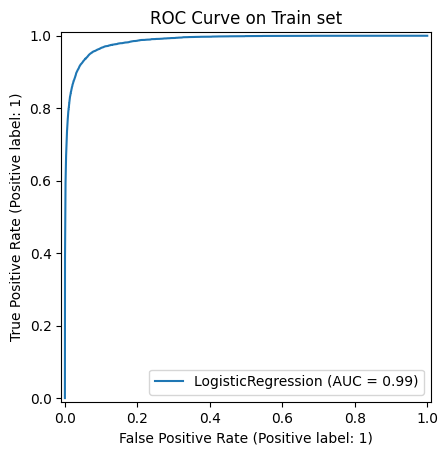

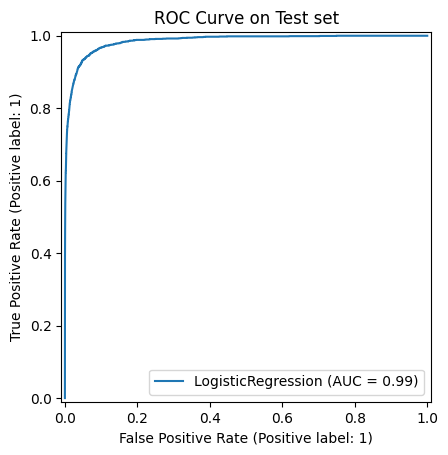

In [14]:
_, ax = plt.subplots()
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_train, Y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    classifier, X_test, Y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

**We improved our f1-score at 76% on the test and train sets. 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [15]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test, axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression(C=1.993327899763547, max_iter=812, penalty='l1',
                   random_state=42, solver='liblinear')

In [16]:
# Read data without labels
data_without_labels = pd.read_csv('../data/raw/conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

Prediction set (without labels) : (31620, 5)


In [17]:
data_without_labels['total_pages_visited_x2'] = data_without_labels['total_pages_visited'] ** 2
data_without_labels['total_pages_visited_age'] = data_without_labels['total_pages_visited'] * data_without_labels['age']
data_without_labels['total_pages_visited_age_x2'] = (data_without_labels['total_pages_visited'] * data_without_labels['age']) ** 2 

In [18]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = preprocessor.transform(data_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30941143 -1.47744289  3.32674998  4.1986833   2.78332904  3.09585156
   0.          1.          0.          0.          1.        ]
 [-1.03585553  0.67684511  0.03723927 -0.18903911 -0.34974221 -0.39545186
   0.          1.          0.          1.          0.        ]
 [ 0.17488463  0.67684511 -1.15894645 -0.64490638 -1.07275865 -0.60048291
   0.          0.          0.          0.          1.        ]
 [ 0.17488463  0.67684511  0.3362857   0.01990005  0.410352    0.06296174
   0.          0.          1.          0.          0.        ]
 [-0.67263348 -1.47744289 -0.56085359 -0.49295062 -0.67417266 -0.51531246
   0.          0.          0.          0.          1.        ]]


In [19]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('../data/processed/conversion_data_test_predictions_Nicolas-Optuna-LogReg-fe.csv', index=False)
